In [2]:
import scipy.io
import numpy as np
import datetime 
import ephem
import random
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib
from astropy.table import Table
import pandas as pd

data=scipy.io.loadmat('BNS-sources-trial-10saleem.mat')['data'] 
#sourceparameters
DL=data[:,0]
theta=data[:,1]
phi=data[:,2]
print(len(DL),len(theta),len(phi))

Using matplotlib backend: MacOSX
220000 220000 220000


In [3]:
#snr at each detector
snrH=data[:,5]
snrL=data[:,6]
snrV=data[:,7]
snrK=data[:,8]
snrI=data[:,9]
#or for networks of 5 and 3 detectors, one can use directly,
snrLHVKI=np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 +data[:,8]**2 + data[:,9]**2)  
# SNR at LHVKI
snrLHV=np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 )  # LHV*
snrLHVK = np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 + data[:,8]**2)
snrLHVI = np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 + data[:,9]**2)
len(snrLHVKI),len(snrLHVK)

(220000, 220000)

In [4]:
from astropy.time import Time
#import random

def homotime(number):
    """
    Defines homogenously distributed time over the time 2022-2023. Number of time elements is essentially the number of
    theta,  phi you get.(220000)
    Takes time in UTC format and gives out time in UTC format
    """
    time1 = Time('2022-01-01T00:00:00.123456789')
    time1 = time1.jd
    time2 = Time('2023-01-01T00:00:00.123456789')
    time2 = time2.jd
    dt = (time2-time1)/number
    homotime = []
    
    for i in range(number):
        if i%(int((number)/10))==0:print(int(i*100/(number)), '% completed', end='\r')
        timejd = time1 + i*dt
        timeutc = Time(timejd, format='jd')
        homotime.append(timeutc.iso)
    print('***Completed***', end='\r')
    #print(len(homotime))
    return homotime
homotime = homotime(len(theta))
len(homotime)

220000

In [5]:
def ecef_eci(lat, lon, time):
    """Convert lat long to right ascention and declination
    lat - latitude of the place where the tigger is at the zenith in degrees
    lon - longitude of the place where the tigger is at the zenith in degrees
    time - UTC time in datetime format
    """
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    temp = time
    year = int(temp[0:4])
    month = int(temp[5:7])
    day = int(temp[8:10])
    hour = int(temp[11:13])
    minu = int(temp[14:16])
    secs = int(temp[17:19])
    #time = Time(time)
    time = datetime.datetime(year, month,day,hour,minu,secs)
    time0 = datetime.datetime(2000, 1, 1, 12, 0, 0)
    time_sid = 18.697374558 + 24.06570982441908*(time - time0).total_seconds()/86400.0
    time_sid = time_sid - 24.0*np.floor(time_sid/24.0)
    dec = lat
    ra = lon + np.pi/24.0*time_sid
    dec = np.rad2deg(dec)
    ra = np.rad2deg(ra)
    return ra,dec


def eci_ecef(ra, dec, time):
    """Convert ra dec to lattitude and longitude
    ra - right ascention of the body in radians
    dec - declination of the body in radians
    time - UTC time in datetime format
    """
#     ra = np.deg2rad(ra)
#     dec = np.deg2rad(dec)
    temp = time
    year = int(temp[0:4])
    month = int(temp[5:7])
    day = int(temp[8:10])
    hour = int(temp[11:13])
    minu = int(temp[14:16])
    secs = int(temp[17:19])
    #time = Time(time)
    time = datetime.datetime(year, month,day,hour,minu,secs)
    time0 = datetime.datetime(2000, 1, 1, 12, 0, 0)
    time_sid = 18.697374558 + 24.06570982441908*(time - time0).total_seconds()/86400.0
    time_sid = time_sid - 24.0*np.floor(time_sid/24.0)
    lon = (ra - 2*np.pi/24.0*time_sid)
    lat = dec
#     lon = np.rad2deg(lon)
#     lat = np.rad2deg(lat)
    return lat, lon

def is_saa(lat, longi, time):
    """Return whether the satellite is in South Atlantic Anamoly or not.
    Hard bounds used from the data of RXTE and assumed that the SAA region is rectangular below the inclination of RXTE.
    
    ra - right ascention of the body in degrees
    dec - declination of the body in degrees
    time - UTC time in datetime format
    """
    # lat, longi = radec2latlong(ra, dec, time)
    #lat, longi = eci_ecef(ra, dec, time)
    lat = np.rad2deg(lat)
    longi = np.rad2deg(longi)
    if -23< lat <= -7 and -90<=longi<=-10:
        return True
    
#     if -90<=longi<=-10:
#         y = 7*longi/80 + 23/8
#         if lat < y:
#             return True
    if -100<=longi<=-35:
        y=14*longi/65+189/13
        if lat<=y:
            return True
    
    if -35<longi<-10:
        y=-14/25*longi-63/5
        if lat<y:
            return True
    
    
    if -10<=longi<=40:
        z = -9*longi/25 -43/5
        if lat<z: 
            return True
	

    if -50<= lat <=-23 and -90<=longi<=40:
        return True
    else: return False 

def getxyz(theta,phi,n):
    if n==1:
        #lat, long
        theta = np.pi/2 - theta
    x=np.sin(theta)*np.cos(phi)
    y=np.sin(theta)*np.sin(phi)
    z=np.cos(theta)
    return x,y,z
def getnorm(vec):
    norm = np.linalg.norm(vec)
    #print (norm)
    return vec/norm

In [6]:
line0 = 'ASTROSAT' #Daksha
line1 = '1 40930U 15052A   22302.17850942  .00000772  00000-0  19439-4 0  9990'
line2 = '2 40930   5.9975   0.5159 0009292 339.1937  20.7998 14.76165238112787'
line3 = '2 40930   5.9975   0.5159 0009292 339.1937 200.7998 14.76165238112787'

# line0 = 'SWIFT'#BAT
# line1 = '1 28485U 04047A   22302.18405080  .00001301  00000-0  60140-4 0  9997'
# line2 = '2 28485  20.5572 277.8742 0011565 130.4507 229.6936 15.03911323708409'
# line0 = 'FGRST (GLAST)'#Fermi
# line1 = '1 33053U 08029A   22100.45970249  .00000511  00000-0  12538-4 0  9998'
# line2 = '2 33053  25.5819 140.4060 0012690 120.1881 239.9912 15.11069703542313'
astrosat1 = ephem.readtle(line0,line1,line2)
astrosat2 = ephem.readtle(line0,line1,line3)

sublat1 = []
sublong1 = []
sublat2 = []
sublong2 = []
for i in range(len(homotime)):
    astrosat1.compute(homotime[i])
    astrosat2.compute(homotime[i])
    sublat1.append(astrosat1.sublat)#sublat in radians
    sublong1.append(astrosat1.sublong)#sublong in radian
    sublat2.append(astrosat2.sublat)#sublat in radians
    sublong2.append(astrosat2.sublong)#sublong in radian
    
#len(sublong1)

In [7]:
sublat1[123], sublat2[123]
np.rad2deg(sublong1[123]), np.rad2deg(sublong2[123])

(-31.305171438040038, 148.4712097623955)

In [8]:
luminosource = []
lumino = []
def randomlumino(number):
    """
    Returns 'number' of Luminosity values between the given caps
    """
   
    lummax = -6
    lummin = -7
    factor = 10**6
    for i in range(number):
        #case1
        luminosource.append(10**(random.randint(lummin*factor,lummax*factor)/factor))
        lumino.append(luminosource[i]*(200**2)/((DL[i])**2)) 
#The nominal flux of a source is between 10^-6 and 10^-7 ergs/cm2/sec IF the source is at 200 Mpc at any other distance, you scale by d^2/D^2

    #df = pd.DataFrame(data=luminosource)
    #df['1'] = lumino
    #df.to_csv('/Users/jinaypatel/Desktop/Daksha/output.csv', sep=',', encoding='utf-8')
    return lumino
    
lumino = randomlumino(len(homotime))
# len(homotime)
# print(lumino)

def is_visible(time,latsat,longsat, lattrig, longtrig, satephem):
    satephem.compute(time)
    theta = 2*np.arcsin(6400000/(6400000+satephem.elevation))
    xsat = np.cos(longsat)*np.sin(np.pi/2 - latsat)
    ysat = np.sin(longsat)*np.sin(np.pi/2 - latsat)
    zsat = np.cos(np.pi/2 - latsat)
    satvec = (xsat,ysat,zsat)
    xtrig = np.cos(longtrig)*np.sin(np.pi/2 - lattrig)
    ytrig = np.sin(longtrig)*np.sin(np.pi/2 - lattrig)
    ztrig = np.cos(np.pi/2 - lattrig)
    trigvec = (xtrig,ytrig,ztrig)
    
    anglebetween = np.arccos(np.dot(satvec,trigvec))
    omegatrig = 2*np.pi*(1- np.cos(np.pi-anglebetween))
    omegashadow = 2*np.pi*(1- np.cos((theta/2)))
#     omegashadow = 2*np.pi*(1-np.cos(np.deg2rad(180-38.7394)))
    if omegashadow>omegatrig:
        return False
    else:
        return True
# plt.hist(np.log10(lumino), bins=100)
#plt.hist(lumino, bins=500)


In [9]:
sensfile = np.loadtxt('sensitivity_20det.csv', delimiter=',',skiprows=1)

In [10]:
thetatransarray = []
phitransarray = []
def transform(astrosat):
    for i in range(len(theta)):
        #if i%10000==0:
            #print(i, end=' ')
        astrosat.compute(homotime[i])
        satvecold = getnorm(getxyz(astrosat.sublat,astrosat.sublong,1))
        tplus = homotime[i][0:17]+(str(int(homotime[i][17:19])+1)) + homotime[i][19:23]
        astrosat.compute(tplus)
        satvecplus = getnorm(getxyz(astrosat.sublat,astrosat.sublong,1))

        zaxis = getnorm(satvecold)
        xaxistemp = getnorm([satvecplus[0]-satvecold[0],satvecplus[1]-satvecold[1],satvecplus[2]-satvecold[2]])
        yaxis = getnorm(np.cross(zaxis,xaxistemp))
        xaxis = getnorm(np.cross(yaxis,zaxis))

        xtrig,ytrig,ztrig = getxyz(theta[i],phi[i],0)
        trigvec = getnorm([xtrig,ytrig,ztrig])

        thetatrans = np.arccos(np.dot(trigvec,zaxis))
        yprojtrig = np.linalg.norm(trigvec)*np.dot(trigvec,yaxis) #np.dot(trigvec,yaxis) gives the angle cos of angle between trigvec and yaxis
        xprojtrig = np.linalg.norm(trigvec)*np.dot(trigvec,xaxis)
        phitrans = np.arctan2(yprojtrig, xprojtrig)
        thetatransarray.append(thetatrans)
        phitransarray.append(phitrans)
    return thetatransarray,phitransarray
# phitrans and thetatrans are the phi and theta of source w.r.t the satellite
theta1,phi1 = transform(astrosat1)
theta2,phi2 = transform(astrosat2)


In [11]:
sensitivitydata1 = []
sensitivitydata2 = []
sensfilethetaphi = []
for i in range(len(sensfile)):
    sensfilethetaphi.append((sensfile[i][0], sensfile[i][1])) #2-D list of theta and phi of sensitivity w.r.t daksha
    

In [12]:
for j in range(len(theta)):
    if j%100==0:
        print(int(j*100/len(theta)),'% Completed', end='\r')
    vectrig = [theta1[j],phi1[j]]
    nearest = sensfilethetaphi[spatial.KDTree(sensfilethetaphi).query(vectrig)[1]]
    for i in range(len(sensfilethetaphi)):
        if sensfilethetaphi[i][0] == nearest[0]:
            if sensfilethetaphi[i][1]==nearest[1]:
                index=i
    sensitivitydata1.append(sensfile[index][3])
    
for j in range(len(theta)):
    if j%100==0:
        print(int(j*100/len(theta)),'% Completed', end='\r')
    vectrig = [theta2[j],phi2[j]]
    nearest = sensfilethetaphi[spatial.KDTree(sensfilethetaphi).query(vectrig)[1]]
    for i in range(len(sensfilethetaphi)):
        if sensfilethetaphi[i][0] == nearest[0]:
            if sensfilethetaphi[i][1]==nearest[1]:
                index=i
    sensitivitydata2.append(sensfile[index][3])

In [13]:
print(len(sensitivitydata2),len(sensitivitydata1))

220000 220000


In [14]:
for k in range(len(sensitivitydata2)):
    if np.isnan(sensitivitydata2[k])==True:
        sensitivitydata2[k] = 0
        
sensdatabackup2 = sensitivitydata2

for k in range(len(sensitivitydata1)):
    if np.isnan(sensitivitydata1[k])==True:
        sensitivitydata1[k] = 0
        
sensdatabackup1 = sensitivitydata1

In [147]:
lumonsatligodaksha = []
#phidecsatligodaksha = []
#thetadecsatligodaksha = []
distsoudecligodaksha = []
#sendecligodakshasat1 = []
#sendecligodakshasat2 = []
lumonsourceligodaksha = []
lumonsourceligoedaksha = []
lumonsatligoedaksha = []
#phidecsatligoedaksha = []
#thetadecsatligoedaksha = []
distsoudecligoedaksha = []
#sendecligoedakshasat1 = []
#sendecligoedakshasat2 = []
distsourcedetligo = []
lumonsatligo = []
snr = 6
for i in range(len(homotime)):
    if lumino[i]>0:
        #detected by both daksha satellite and LIGO
        if is_saa(sublat1[i],sublong1[i], homotime[i])==False and snrLHV[i]>=snr and sensitivitydata1[i]<=lumino[i] and is_visible(homotime[i],sublat1[i],sublong1[i],np.deg2rad(90.0) - theta1[i],phi1[i], astrosat1)==True:
            if is_saa(sublat2[i],sublong2[i], homotime[i])==False and snrLHV[i]>=snr and sensitivitydata2[i]<=lumino[i] and is_visible(homotime[i],sublat2[i],sublong2[i],np.deg2rad(90.0) - theta2[i],phi2[i], astrosat2)==True:
                    lumonsatligodaksha.append(lumino[i])
                    lumonsourceligodaksha.append(luminosource[i])
                    distsoudecligodaksha.append(DL[i])
                    #thetadecsatligodaksha.append(theta1[i])
                    #phidecsatligodaksha.append(phi1[i])
                    #sendecligodakshasat1.append(sensitivitydata1[i])
                    #sendecligodakshasat2.append(sensitivitydata2[i])
                    
        if snrLHV[i]>=snr:
            distsourcedetligo.append(DL[i])
            lumonsatligo.append(lumino[i])
            
#df = pd.DataFrame(data=lumonsatligodaksha)
#df['Luminosity of source'] = lumonsourceligodaksha
#df['Theta'] = thetadecsatligodaksha
#df['Phi'] = phidecsatligodaksha
#df['Distance'] = distsoudecligodaksha
#df['Sensitivity of Satellite 1'] = sendecligodakshasat1
#df['Sensitivity of Satellite 2'] = sendecligodakshasat2
#df.to_csv('/Users/jinaypatel/Desktop/Daksha/LHV_DakshaplusLIGO.csv', sep=',', encoding='utf-8')
for j in range(len(homotime)): 
    if lumino[j]>0:
        #detected by either one of the daksha satellite and LIGO
        if (is_saa(sublat1[j],sublong1[j], homotime[j])==False and snrLHV[j]>=snr and sensitivitydata1[j]<=lumino[j] and is_visible(homotime[j],sublat1[i],sublong1[j],np.deg2rad(90.0) - theta1[j],phi1[j], astrosat1)==True) or (is_saa(sublat2[j],sublong2[j], homotime[j])==False and snrLHV[j]>=snr and sensitivitydata2[j]<=lumino[j] and is_visible(homotime[j],sublat2[i],sublong2[j],np.deg2rad(90.0) - theta2[j],phi2[j], astrosat2)==True):
            lumonsatligoedaksha.append(lumino[j])
            lumonsourceligoedaksha.append(luminosource[j])
            distsoudecligoedaksha.append(DL[j])
            #thetadecsatligoedaksha.append(theta1[j])
            #phidecsatligoedaksha.append(phi1[j])
            #sendecligoedakshasat1.append(sensitivitydata1[j])
            #sendecligoedakshasat2.append(sensitivitydata2[j])
       # if is_saa(sublat2[j],sublong2[j], homotime[j])==False and snrLHVKI[j]>=snr and sensitivitydata2[j]<=lumino[j] and is_visible(homotime[j],sublat2[i],sublong2[j],np.deg2rad(90.0) - theta2[j],phi2[j], astrosat2)==True:
        """"    lumonsatligoedaksha.append(lumino[j])
            lumonsourceligoedaksha.append(luminosource[j])
            thetadecsatligoedaksha.append(theta1[j])
            phidecsatligoedaksha.append(phi1[j])
            distsoudecligoedaksha.append(DL[j])
            sendecligoedakshasat1.append(sensitivitydata1[j])
            sendecligoedakshasat2.append(sensitivitydata2[j])"""


#print(len( lumonsatligoedaksha),len(lumonsatligodaksha))
print(len(distsourcedetligo),len(distsoudecligodaksha))
#df = pd.DataFrame(data=lumonsatligodaksha)
#df['Luminosity of Source'] = lumonsourceligodaksha
#df['Theta'] = thetadecsatligodaksha
#df['Phi'] = phidecsatligodaksha
#df['Distance'] = distsoudecligodaksha
#df['Sensitivity of Satellite 1'] = sendecligodakshasat1
#df['Sensitivity of Satellite 2'] = sendecligodakshasat2
#df.to_csv('/Users/jinaypatel/Desktop/Daksha/LHV_Dakshaonly.csv', sep=',', encoding='utf-8')

45001 11214


0.24919446234528123


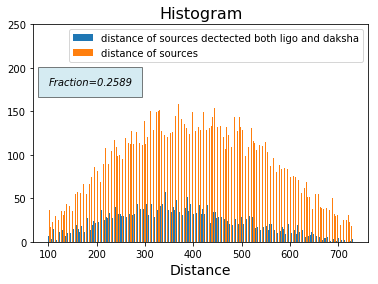

In [148]:
plt.hist([distsoudecligodaksha,distsourcedetligo],bins=500,label=['distance of sources dectected both ligo and daksha','distance of sources'])
plt.title('Histogram', fontsize=16)
plt.xlabel('Distance', fontsize=14)
plt.legend()
plt.ylim(0,250)
plt.text(100, 180, 'Fraction=0.2589', style='italic',
        bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10})
print(len(distsoudecligodaksha)/len(distsourcedetligo))

0.7254061020866203


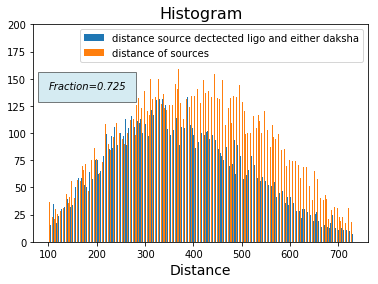

In [155]:
plt.hist([distsoudecligoedaksha,distsourcedetligo],bins=500,label=['distance source dectected ligo and either daksha','distance of sources'])
plt.title('Histogram', fontsize=16)
plt.xlabel('Distance', fontsize=14)
plt.legend()
plt.ylim(0,200)
plt.text(100, 140, 'Fraction=0.725', style='italic',
        bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10})
print(len(distsoudecligoedaksha)/len(distsourcedetligo))

5.450212161820026e-07 8.926570577108464e-08


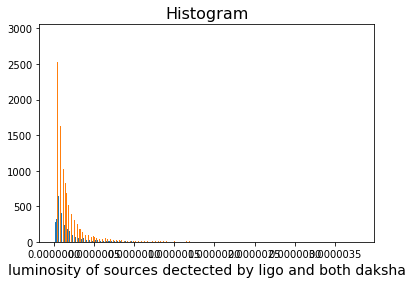

In [156]:
plt.hist([lumonsatligodaksha,lumonsatligo],bins=500,label=['distance source dectected ligo and either daksha','distance of sources'])
plt.title('Histogram', fontsize=16)
plt.xlabel('luminosity of sources dectected by ligo and both daksha', fontsize=14)
print(lumonsatligodaksha[2],lumonsatligo[2])

(0, 1e-06)

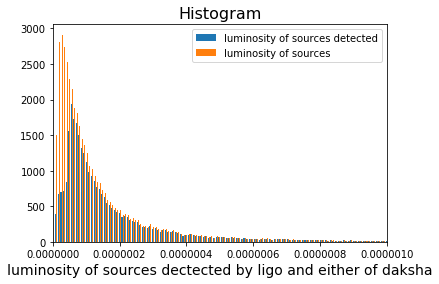

In [158]:
plt.hist([lumonsatligoedaksha,lumonsatligo],bins=500,label=['luminosity of sources detected','luminosity of sources'])
plt.title('Histogram', fontsize=16)
plt.legend()
plt.xlabel('luminosity of sources dectected by ligo and either of daksha', fontsize=14)
plt.xlim(0,0.00000100)